# Сегментация клиентов банка по количеству потребляемых продуктов

**Цель:**
Выделить среди пользователей различного количества продуктов разнообразные, но однородные внутри сегменты таким образом, чтобы изменение банковских продуктов приводило к уменьшению оттока

**Задачи:**

- Провести исследовательский анализ, включающий исследование корреляций и портретов клиентов
- Проверить гипотезы
- Определить, какие признаки влияют на количество используемых продуктов
- Выделить с применением количества продуктов высокоотточные сегменты и приоритизировать их
- Дать рекомендации по приоритетным сегментам
- Подготовить презентацию

**Заказчик:** отдел маркетинга "Метанпромбанка"

**Описание данных:**

Датасет содержит данные о клиентах «Метанпромбанка». Отделения банка находятся в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки датасета:

- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- city — город,
- gender — пол,
- age — возраст,
- equity — приблизительная оценка собственности клиентов,
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- credit_card — есть ли кредитная карта,
- last_activity — был ли клиент активен в последний месяц,
- estimated_salary — заработная плата клиента,
- churn — уходит или нет.

## Загрузка данных

In [1]:
# подключаем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from plotly import graph_objects as go
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
#import matplotlib.ticker
from statsmodels.stats.proportion import proportions_ztest
from functools import reduce
import warnings

In [2]:
# загружаем данные
data = pd.read_csv('https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F')

In [3]:
# знакомимся с данными
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


## Предобработка данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


In [6]:
# Смотрим количество строк и столбцов
data.shape

(10000, 12)

**Анализ пропусков и их кодирование**

In [7]:
#cчитаем пропуски
data.isna().sum()

USERID              0
score               0
city                0
gender              0
age                 0
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

In [8]:
print('Процент пропусков в столбце balance - {} % '. format(round(data['balance'].isnull().sum()/len(data)*100, 2)))

Процент пропусков в столбце balance - 22.95 % 


Процент пропусков достаточно высокий. Проверим, был ли массовый технический сбой.

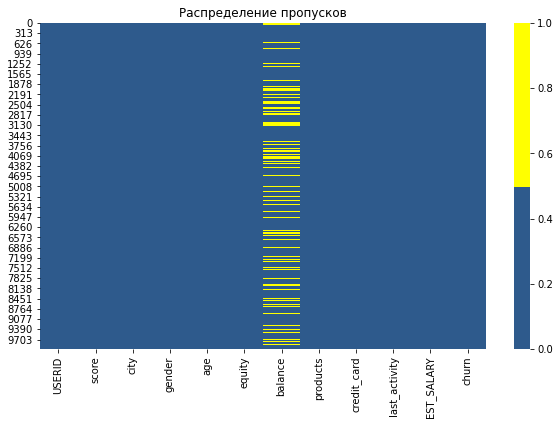

In [9]:
plt.figure(figsize=(10,6))
plt.title('Распределение пропусков')
colours = ['#2e5a8c', '#ffff00'] 
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))
plt.show()

На диаграмме мы видим, что пропуски есть у клиентов с разными userId, начиная с первых, заканчивая последними, зарегистрированными в базе банка. Т.е. появление пропусков в столбце balance не является временным явлением.

Попробуем выявить другую закономерность появления пропусков. 

In [10]:
# запишем в отдельный датафрейм данные по клиентам с пропусками по балансу, уберем столбец userid
nobalance = data[data['balance'].isnull()]
nobalance = nobalance.drop(columns='USERID') 

Наиболее вероятной предполагаемой причиной, по которой могли бы появляться пропуски баланса, является уход клиента и перевод денег в другой банк. Проверим предположение.

In [11]:
nobalance['churn'].value_counts(normalize=True)

0    0.994336
1    0.005664
Name: churn, dtype: float64

Предположение не подтвердилось. 99,4% клиентов с пропусками в столбце balance не уходят.

Посмотрим на центральные тенденции характеристик в разрезе продуктов.

In [12]:
nobalance = pd.get_dummies(nobalance, columns=['products'], drop_first=False)

In [13]:
nobalance.describe()

,score,age,equity,balance,credit_card,last_activity,EST_SALARY,churn,products_0,products_1,products_2,products_3
count,2295.000000,2295.000000,2295.000000,0.0,2295.000000,2295.000000,2.295000e+03,2295.000000,2295.000000,2295.000000,2295.000000,2295.000000
mean,865.352070,41.849237,0.050980,NaN,0.815686,0.549455,2.263102e+05,0.005664,0.000436,0.849673,0.137255,0.012636
std,89.603091,11.737574,0.225872,NaN,0.387824,0.497657,1.997718e+05,0.075066,0.020874,0.357469,0.344191,0.111723
min,642.000000,18.000000,0.000000,NaN,0.000000,0.000000,2.027403e+04,0.000000,0.000000,0.000000,0.000000,0.000000
25%,871.000000,33.000000,0.000000,NaN,1.000000,0.000000,1.203477e+05,0.000000,0.000000,1.000000,0.000000,0.000000
50%,903.000000,39.000000,0.000000,NaN,1.000000,1.000000,1.741607e+05,0.000000,0.000000,1.000000,0.000000,0.000000
75%,922.000000,49.000000,0.000000,NaN,1.000000,1.000000,2.400150e+05,0.000000,0.000000,1.000000,0.000000,0.000000
max,990.000000,86.000000,3.000000,NaN,1.000000,1.000000,1.333687e+06,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# проверяем связь с городом
nobalance['city'].value_counts(normalize=True)

Ярославль    0.644009
Рыбинск      0.251852
Ростов       0.104139
Name: city, dtype: float64

In [15]:
# для сравнения смотрим, как распределяются по городам клиенты с заполненным полем balance
balance = data[data['balance'].notnull()]
balance['city'].value_counts(normalize=True)

Ярославль    0.574692
Рыбинск      0.270604
Ростов       0.154705
Name: city, dtype: float64

Проблема пропусков наблюдается во всех отделениях банка. Выделить зависимость с каким-то конкретным городом мы не можем.

In [16]:
nobalance['equity'].value_counts(normalize=True)

0    0.949891
1    0.049673
3    0.000436
Name: equity, dtype: float64

Почти 95% клиентов не имеют собственности, всего 5% имеют показатель equity=1. Обладатели большого количества собственности не имеют пропущенных значений по балансу

In [17]:
# посмотрим в каком соотношении по наличию собственности рапределелись клиенты, имеющие баланс
balance['equity'].value_counts(normalize=True)

5    0.248929
4    0.240104
3    0.200130
2    0.136535
1    0.085659
0    0.053472
6    0.020896
7    0.010383
8    0.002206
9    0.001687
Name: equity, dtype: float64

Проверим также, встречаются ли нулевые значения баланса.

In [18]:
# считаем количество нулевых значений в balance
data.query('balance == 0')['balance'].count()

2

Нулевые значения присутствуют, а значит, причина пропусков не связана с нулевым балансом.

In [19]:
# посчитаем тех, у кого кр. карта есть, всего один продукт, нет недвижимости, баланс пропущен
#b_0 = data.query('credit_card == 1 and products == 1 and balance.isnull()')['USERID'].count()
b_0 = data.loc[((data['credit_card'] == 1) & (data['products'] == 1) & (data['equity'] == 0) & (data['balance'].isnull()))]['USERID'].count()

In [20]:
# посчитаем тех, у кого кр. карта есть, всего один продукт, баланс пропущен
b_0_cp = data.loc[((data['credit_card'] == 1) & (data['products'] == 1) & (data['balance'].isnull()))]['USERID'].count()

In [21]:
# посчитаем тех, у кого кр. карта есть, нет недвижимости, баланс пропущен
b_0_ce = data.loc[((data['credit_card'] == 1) & (data['equity'] == 0) & (data['balance'].isnull()))]['USERID'].count()

In [22]:
# посчитаем всех, у кого пропущен баланс, без связи с другими признаками
b_0_all = data[data['balance'].isnull()]['USERID'].count()

In [23]:
# процент тех, у кого кр. карта есть и всего один продукт от общего числа клиентов без баланса
f'{round(b_0 / b_0_all, 2):.2%}'

'66.00%'

In [24]:
# процент тех, у кого совпали все признаки от общего числа клиентов без баланса
f'{round(b_0_cp / b_0_all, 2):.2%}'

'70.00%'

In [25]:
# процент тех, у кого кр. карта есть, нет недвижимости от общего числа клиентов без баланса
f'{round(b_0_ce / b_0_all, 2):.2%}'

'77.00%'

In [26]:
# сколько в датасете пропусков, не связанных ни с одним из выявленных признаков
data.loc[((data['credit_card'] != 1) & (data['products'] != 1) & (data['equity'] != 0) & (data['balance'].isnull()))]['USERID'].count()

4

Вывод:

Из полученных данных видна следующая связь:

По продуктам - почти 85% клиентов из тех, что пользуются одним продуктом имеют пропуски баланса. Клиенты с другим количеством продуктов пропусков по балансу либо не имеют (4 и 5 продуктов), либо имеют очень мало.
По наличию кредитной карты - почти 82% клиентов, имеющих кредитную карту, имеют пропуски по балансу.
По наличию собственности - 95% клиентов из тех, у кого пропуски в balance собственности не имеет.
Дополнительно были проведены расчеты, помогающие определить, насколько сильна взаимосвязь нескольких признаков между собой:

По продукту + кредитной карте + собственности - 66% имеют единственный продукт, кот-й является кредитной картой и не имеют недвижимости.
По продукту + кредитной карте - 70% используют 1 продукт и имеют кред. карту.
По кредитной карте + собственности - 77% имеют кредитку и не имеют собственности.
Основываясь на проведенных расчетах и установленных связях признаков, мы можем сделать вывод о том, что появление большинства пропусков в поле balance не случайно.

Я считаю, что пропуски можно отнести к типу MAR.

MAR (Missing At Random) — на практике данные обычно пропущены не случайно, а ввиду некоторых закономерностей. Пропуски относят к MAR, если вероятность пропуска может быть определена на основе другой имеющейся в наборе данных информации, не содержащей пропуски.

Но удалить строки, содержащие пропуски мы не можем, т.к. их слишком много и это может повлиять на дальнейшее исследование. Оставим записи с пропусками, как есть.

**Проверка корректности наименования колонок. Переименование колонок**

In [27]:
# приведем названия столбцов к единому стилю
data = data.rename(str.lower, axis = 'columns')
data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

**Проверка данных на наличие дубликатов**

Проверим на наличие полных дубликатов.

In [28]:
# количество полных дубликатов
data.duplicated().sum()

1

In [29]:
# вывод полных дубликатов
duplicateRows = data[data.duplicated ()]
duplicateRows

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
9457,141945,929.0,Ярославль,М,33,0,NaN,1,1,0,381868.89,0


В данных имеется одна строка, являющаяся дубликатом. Удалим ее.

In [30]:
# удаление дубликата
data = data.drop_duplicates()

Выполним проверку на наличие неполных дубликатов.

In [31]:
data.duplicated(['userid']).sum()

72

In [32]:
# получим список userid, у которых есть дубликаты
userid_dupl = data[data.duplicated(['userid'])]['userid']

# создадим новый датафрейм, состоящий только из строк, имеющих дубликаты по столбцу userid
du = data.query('userid in @userid_dupl').sort_values(by='userid')
du

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7694,116540,887.0,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0
1893,116540,883.0,Ярославль,Ж,55,1,362756.49,3,0,1,175920.48,1
4866,117943,855.0,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0
5863,120258,908.0,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990.0,Ярославль,М,37,4,14648692.14,2,0,0,934412.61,1
8205,227795,840.0,Рыбинск,М,34,2,350768.03,1,1,0,102036.14,1
8497,227795,839.0,Рыбинск,М,34,2,326593.14,2,1,0,103314.92,0
6457,228075,839.0,Ярославль,М,39,5,507199.85,3,0,1,85195.80,0


В нормализованной базе данных поле userid должно быть уникальным, у нас же в данных есть повторы. Если попарно посмотреть строки с одинаковым значением userid, то увидим, что в большинстве случаев значения остальных столбцов отличаются, что говорит о том, что один и тот же идентификатор присвоен совершенно разным лицам. Т.к. 72 записи составляют менее одного процента от общего количества записей, мы можем их удалить.

In [33]:
# удалим дубликаты по столбцу userid
data = data.drop_duplicates(subset=['userid'])
data.shape[0]

9927

**Кодирование категориальных данных**

Столбцы gender и city содержат неупорядоченные категориальные данные. Выполним подготовку к дальнейшему анализу, заменив такие данные на бинарные значения, применив one-hot кодирование.

In [34]:
# чтобы не потерять данные оригинальных столбцов, создадим их копии
data['city_new'] = data['city']
data['gender_new'] = data['gender']
data = pd.get_dummies(data, columns=['city', 'gender'], drop_first=False)

In [35]:
data.head()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_new,gender_new,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,183012,850.0,25,1,59214.82,2,0,1,75719.14,1,Рыбинск,Ж,0,1,0,1,0
1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,Рыбинск,Ж,0,1,0,1,0
2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,Рыбинск,Ж,0,1,0,1,0
3,225363,866.0,51,5,1524746.26,2,0,1,174423.53,1,Ярославль,Ж,0,0,1,1,0
4,157978,730.0,34,5,174.00,1,1,0,67353.16,1,Ярославль,М,0,0,1,0,1


**Проверка данных на наличие аномальных значений**

In [36]:
print('Минимальный возраст клиента: ', data['age'].min())

Минимальный возраст клиента:  18


In [37]:
print('Максимальный возраст клиента: ', data['age'].max())

Максимальный возраст клиента:  86


Несовершеннолетний возраст не встречается, так же как и аномальные значения, которых не может быть.

In [38]:
data['est_salary'].min()

2546.3

Минимальное значение заработной платы 2546.3. Кажется, что слишком мало, но ведь заработной платой, например, модель могла посчитать стипендию студента. Такие суммы нельзя считать аномалиями и отсекать клиентов с такой зарплатой нельзя.

Верхняя граница не может быть ограничена, т.к. доходы у людей могут быть разными. Поэтому данные по зарплате можно считать пригодными для анализа.

In [39]:
data['balance'].min()

0.0

Аномалным значением в столбце balance вероятно можно было бы считать отричательное значение. Но у нас минимальное значение - 0.

In [40]:
print('Минимальный балл кредитного скоринга: ', data['score'].min())
print('Максимальный балл кредитного скоринга: ', data['score'].max())

Минимальный балл кредитного скоринга:  642.0
Максимальный балл кредитного скоринга:  1000.0


Теперь посмотрим, какие значения есть в поле products

In [41]:
data['products'].unique()

array([2, 3, 1, 4, 5, 0])

Клиенты банка должны иметь хотя бы один продукт, иначе, что их связывает с банком? Но в наших данных есть записи с нулевыми значениями в поле products. Проверим количество таких записей.

In [42]:
print('Количество записей, в которых поле products имеет нулевое значение: ', data.query('products == 0')['products'].count())

Количество записей, в которых поле products имеет нулевое значение:  1


Запись всего одна. Вероятно, просто не успели удалить ушедшего клиента из базы. Удалим эту запись.

In [43]:
# удаляем строку
data = data.query('products != 0')
data.shape[0]

9926

***Вывод***

В процессе знакомства с данными и их подготовки к дальнейшему исследованию было выявлено следующее:

- В исходном датасете содержится 10 000 строк, из них 22.95 % имеют пропуски в столбце balance. В остальных столбцах пропусков нет. Определенной связи пропусков с каким-то конкретным признаком выявлено не было. С временному сбою в работе мы также не можем отнести данную проблему. Вероятно, пропуски связаны с какой-то технической ошибкой (например, в обнулившемся балансе не проставляется ноль, а появляется пропуск; выгрузка формируется некорректно и т.п.). В проблеме нужно разбираться. На данном этапе было принято решение записи сохранить, пропуски заменить нулем.

- В данных имеются дубликаты: один полный и 72 дубликата по полю userid (чего не должно было бы быть, т.к. это поле является уникалным идентификатором пользователя). Выявленные дубликаты были удалены.

- В столбцах city и gender содежатся неупорядоченные категориальные данные. Для удобства проведения дальнейшего исследования было выполнено их кодирование путем замены на бинарные значения. Оригинальные даные были сохранены.

- Аномальных значений выявлено не было, за исключением одной записи, содержащей ноль в столбце products, эта запись была удалена.

## Исследовательский анализ данных

### Изучение основных статистических характеристик

Посмотрим на общую статистику по датасету:

In [44]:
data.drop(['userid'], axis=1).describe()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
count,9926.000000,9926.000000,9926.000000,7.667000e+03,9926.000000,9926.000000,9926.000000,9.926000e+03,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000,9926.000000
mean,848.724562,42.829438,2.634596,8.289016e+05,1.875781,0.679931,0.523574,1.479038e+05,0.183357,0.143159,0.266069,0.590772,0.498993,0.501007
std,65.386276,12.121227,1.979382,1.985272e+06,0.800116,0.466526,0.499469,1.393674e+05,0.386978,0.350253,0.441923,0.491716,0.500024,0.500024
min,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,802.000000,34.000000,0.000000,2.952611e+05,1.000000,0.000000,0.000000,7.525207e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,853.000000,40.000000,3.000000,5.248943e+05,2.000000,1.000000,1.000000,1.197154e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,900.000000,51.000000,4.000000,9.808015e+05,2.000000,1.000000,1.000000,1.746796e+05,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Из полученных статистических характеристик видим:
- Среди клиентов мы имеем примерно одинаковое количество мужчин и женщин
- По георграфическому признаку клиенты распределены следующим образом:
    - 59% - в Ярославле
    - 27% - в Рыбинске
    - 14% - в Ростове Великом
- Средний возраст - 42 года (медианное значение - 40 лет)
- Отточных клиентов 18%
- В среднем клиенты используют два продукта банка
- Чуть больше половины в последнее время совершали какие-то активные действия
- Медиана по заработной плате клиентов - 119715 руб.
- 68 % процентов клиентов пользуются продуктом "Кредитная карта"
- Медиана по скоринговому коэффициенту - 853

### Построение графиков. Распределение клиентов по признакам

**Распределение по категориям в разрезе отточности**

Рассмотрим распределение клиентов по категориям 'score', 'estimated_salary', 'age' в разрезе признака churn (отточность).
Строим гистограммы.

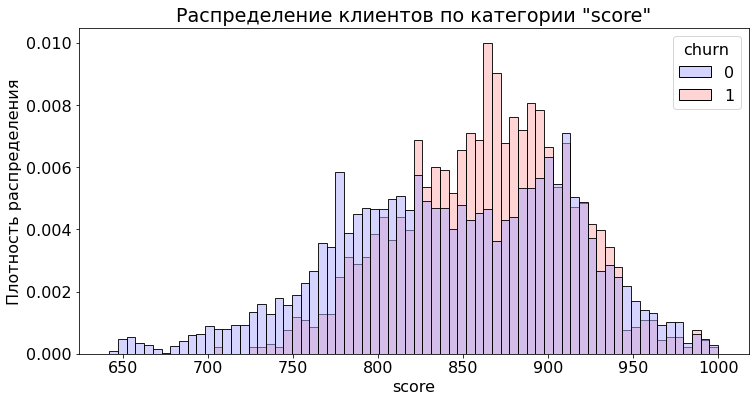

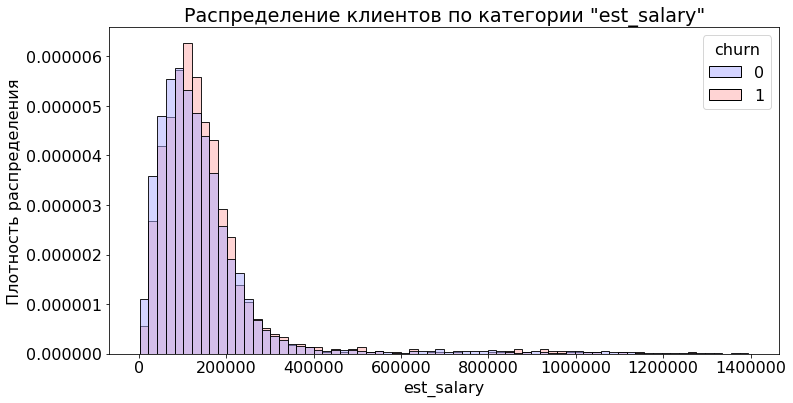

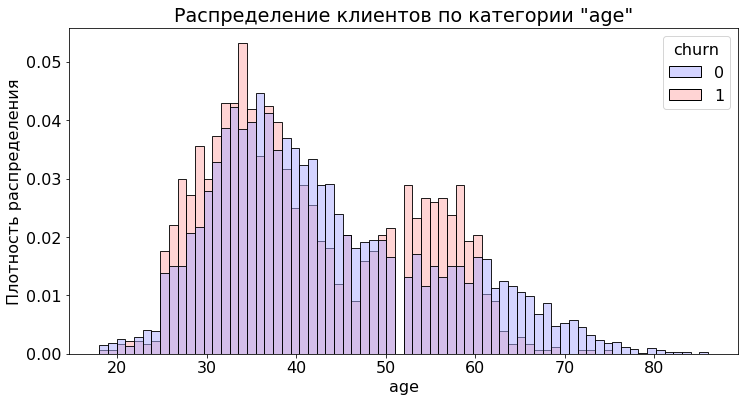

In [45]:
columns = ['score', 'est_salary', 'age']
for column in columns:
    plt.figure(figsize=(12,6))
    plt.rcParams.update({'font.size': 16})
    ax = sns.histplot(x=column,  data=data, hue='churn', palette="bwr", stat="density", common_norm=False, bins=70)
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title(f'Распределение клиентов по категории "{column}"')
    ax.set_xlabel(column)
    ax.set_ylabel('Плотность распределения')
    plt.show() 

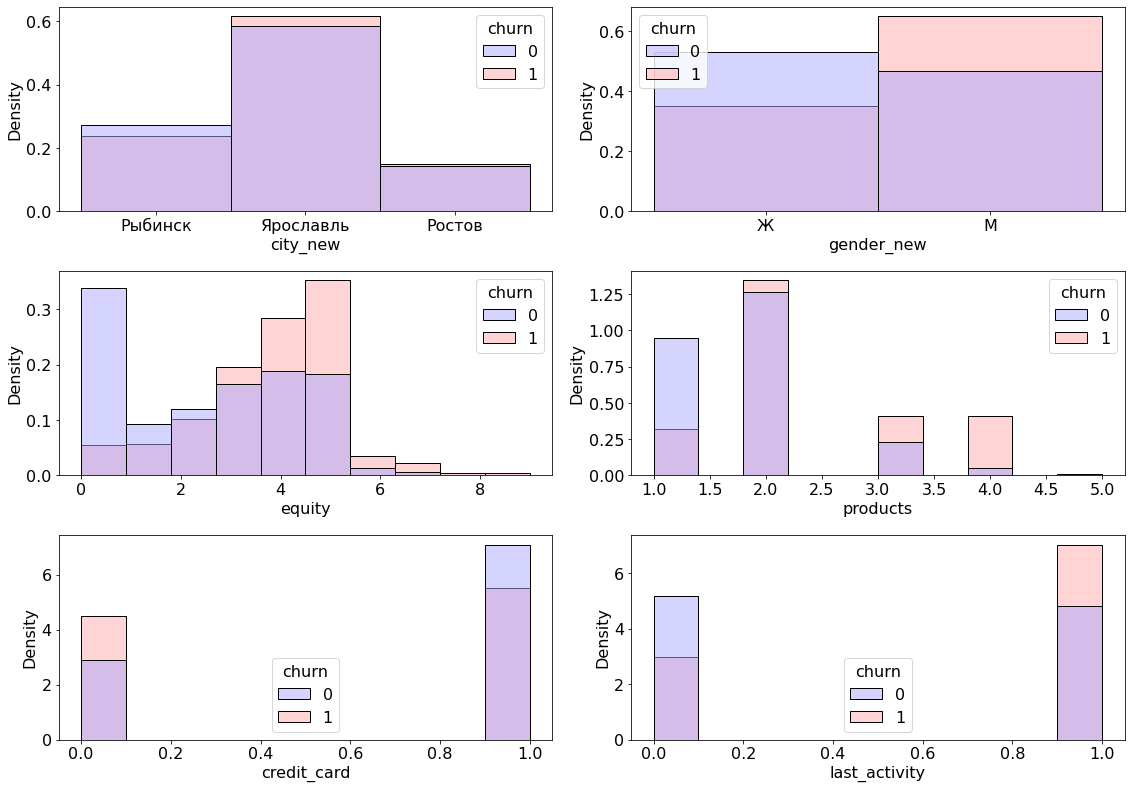

In [46]:
column_cat = ['city_new', 'gender_new', 'equity', 'products', 'credit_card', 'last_activity']
plt.figure(figsize=(16,18))
for i, column in enumerate (column_cat):
    sns.histplot(x = data[column], hue='churn', data=data, stat="density", common_norm=False, 
                 palette="bwr", ax=plt.subplot(5, 2, i + 1), bins=10)
    #plt.title(column)
    plt.tight_layout()


Для признака balance построим график boxplot

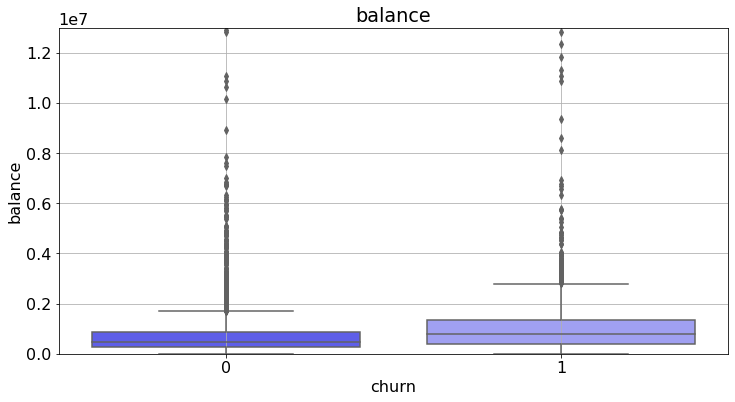

In [47]:
plt.figure(figsize=(12,6))
sns.boxplot(x = 'churn', y = data['balance'], data = data, palette = sns.color_palette('bwr'))
plt.title('balance')
plt.grid()
plt.ylim(0, 13000000)
plt.show()

Для того, чтобы построить информативный график распределения значений баланса по группам,  будем отфильтровывать данные, исходя из нормального размаха (возьмем 95% наблюдений по balance):

In [48]:
balance_95 = data['balance'].quantile([.0, .95])
balance_95

0.00          0.000
0.95    2120652.508
Name: balance, dtype: float64

In [49]:
data_clip = data.copy()

In [50]:
data_clip.balance =  np.clip(data_clip.balance, 0, 2000000)

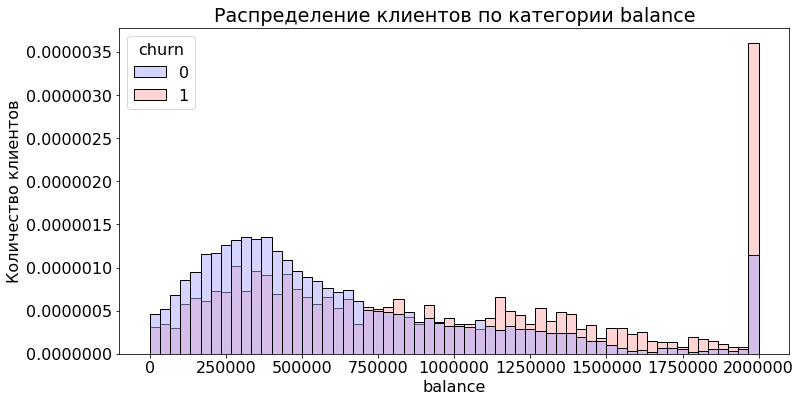

In [51]:
plt.subplots(figsize=(12, 6))
ax = sns.histplot(data_clip, x = data_clip['balance'], hue='churn', palette="bwr", stat="density", common_norm=False, bins=60)
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title(f'Распределение клиентов по категории balance')
ax.set_ylabel('Количество клиентов')
plt.show()

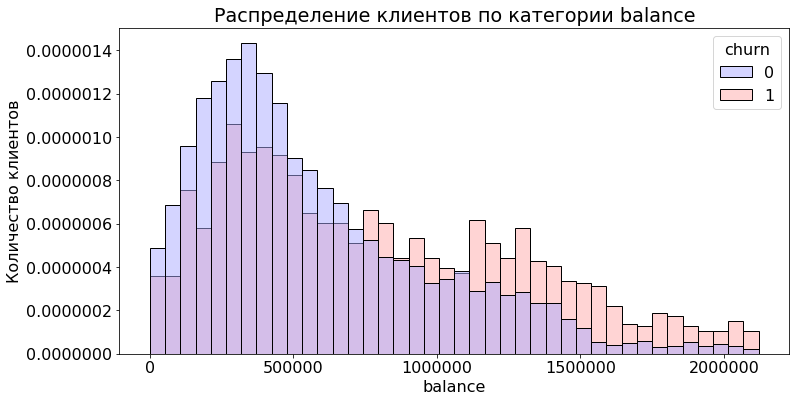

In [52]:
plt.subplots(figsize=(12, 6))
data_95 = data.query('balance <= @balance_95.max()')
ax = sns.histplot(data_95, x = data_95['balance'], hue='churn', palette="bwr", stat="density", common_norm=False, bins=40)
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title(f'Распределение клиентов по категории balance')
ax.set_ylabel('Количество клиентов')
plt.show()


В разрезе отточности на графиках видны следующие особенности:

- Достаточно многочисленный сегмент, имеющий высокий кредитный рейтинг (820-940 баллов) является отточным.
- Большая часть клиентов, имеющих зарплату от 100 000 руб. до 220 000 руб. С меньшей зарплатой отточности нет.
- По возрасту в интервалах с 25 до 36 лет и с 50 до 61 года - преобладает отток. 
- Во всех городах соотношение отточных и неотточных клиаентов примерно одинаковое, город явно не влияет на такой признак, как отточность.
- По полу - клиентов-мужчин в нашем банке больше, но процент оттока среди них выше. А вот большую часть женщин, видимо, наш банк устраивает и они не уходят.
- По наличию собственности наблюдаются следующие особенности: процент клиентов, не имеющих собственности, очень высок и такие клиенты, видимо, заинтересованы в нашем банке, т.к. процент оттока среди них низок. С невысоким баллом оценки по данному показателю (от 1 до 2) - также больше тех, кто остается, хотя, по отношению к предыдщему нулевому сегменту, их процент меньше. Среди тех, кто имеет оценку собственности 3+ уже начинают преобладать уходящие в отток клиенты.
- По продуктам. Пользователи одного продукта в большинстве своем остаются. Среди пользователей 2-х продуктов отточных клиентов больше, чем неотточных, но ненамного. А вот те, кто используют 3 продукта и более - явно отточный сегмент.
- Пользователей, которые имеют кредитную карту гораздо больше, чем тех, кто не имеет. Процент оттока у обладателей кредитных карт невысокий, а вот те, кто данный продукт не использует, в основном уходят. Условия кредитных карт явно нравятся нашим клиентам, стоит задуматься о мерах продвижения данного продукта.
- Большая часть активных пользователей уходит из банка, а неактивных остается. Но мы точно не знаем, какая именно активность подразумевается в наших данных. Если это любое обращение в банк, то подача клиентом заявки о закрытии счетов - это тоже активное действие. 
- По балансу на счете разброс очень большой, есть клиенты, имеющие очень крупные суммы на счете. Но для того, чтобы наглядно увидеть распределение баланса среди клиентов на графике, мы отбросили небольшую часть, отфильтровав по 95 перцентилю. По графику видно, что клиенты, у которых баланс находится в интервале от 0 до 750 000 руб., в основном остаются в банке, те же, кто имеет сумму на счете больше - в основном уходят. 


**Распределение по категориям в разрезе продуктов**

Теперь посмотрим распределение клиентов по категориям в разрезе признака products. Т.к. группы с четырьмя и пятью продуктами являются малочисленными относительно общей выборки, объединим их в одну группу и обозначим ее "4"

In [53]:
data_prod = data.copy()
data_prod['products'] = data_prod['products'].replace(5, 4)

Сначала построим графики для переменных 'score', 'estimated_salary', 'age'.

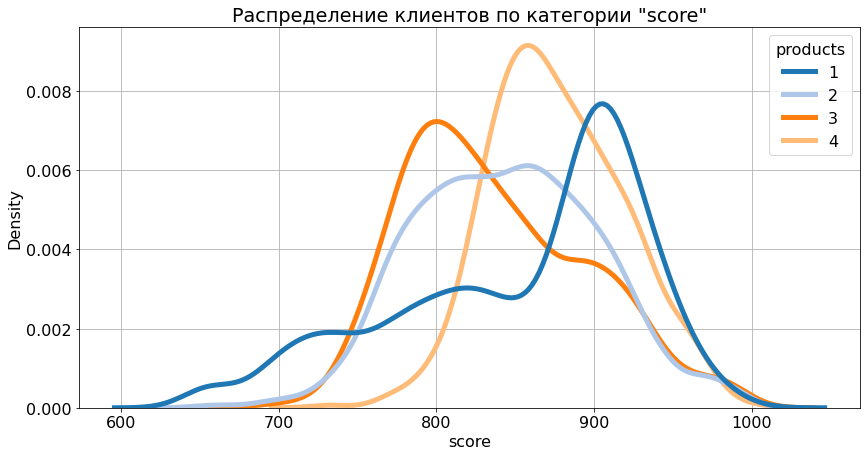

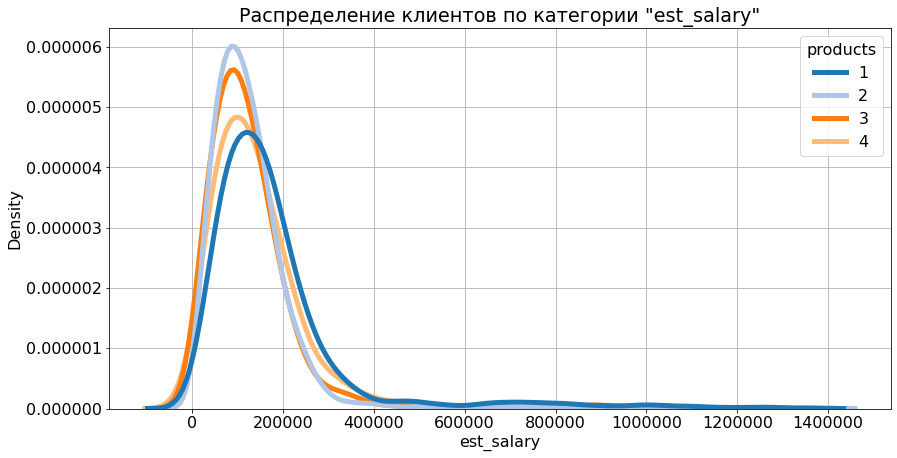

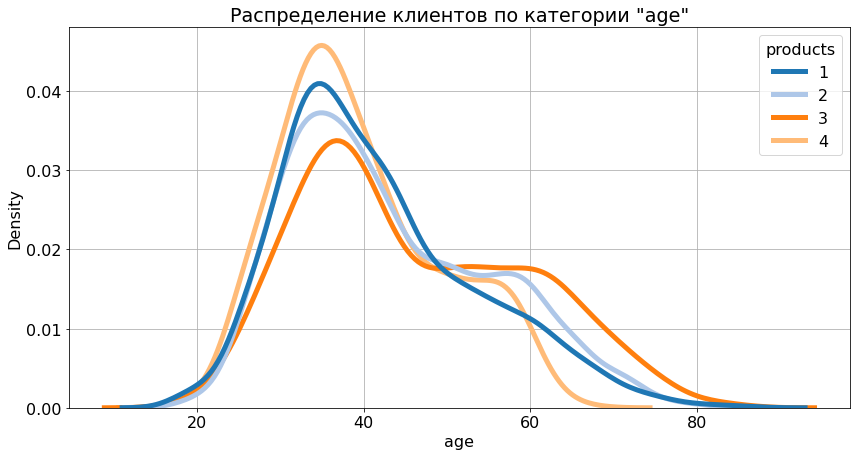

In [54]:
columns = ['score', 'est_salary', 'age']
for column in columns:
    plt.figure(figsize=(14,7))
    plt.rcParams.update({'font.size': 16})
    ax = sns.kdeplot(x=column,  data=data_prod, hue='products', common_norm=False, palette="tab20", linewidth = 5)
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title(f'Распределение клиентов по категории "{column}"')
    ax.set_xlabel(column)
    plt.grid()
    plt.show() 

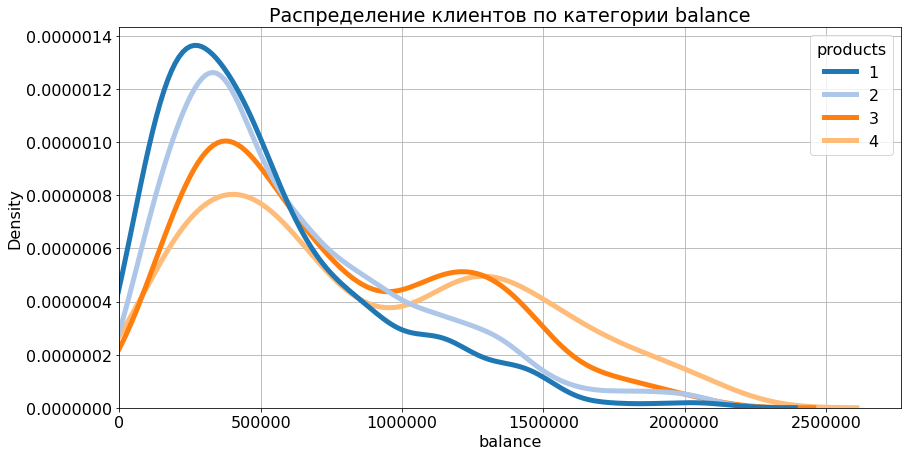

In [55]:
balance_prod_95 = data_prod['balance'].quantile([.0, .95]) 
data_prod_95 = data_prod.query('balance <= @balance_prod_95.max()')
plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 16})
ax = sns.kdeplot(x=data_prod_95['balance'],  data=data_prod_95, hue='products', common_norm=False, palette="tab20", linewidth = 5)
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title(f'Распределение клиентов по категории balance')
plt.xlim(0)
plt.grid()
plt.show() 

Рассмотрим распределение клиентов по категориям 'city', 'gender', 'equity', 'products', 'credit_card', 'last_activity' в разрезе признака products. 

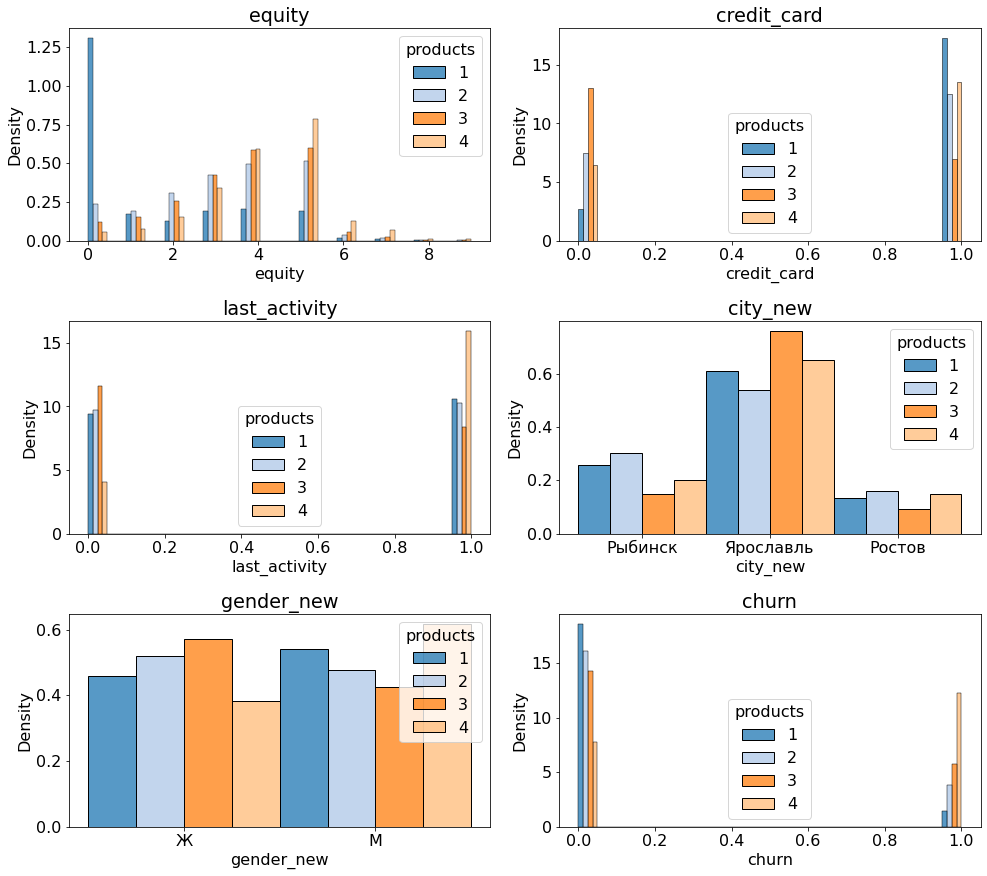

In [56]:
column_cat = ['equity', 'credit_card', 'last_activity', 'city_new', 'gender_new', 'churn']
plt.figure(figsize=(14,20))
for i, column in enumerate (column_cat):
    sns.histplot(x = data_prod[column], hue='products', data=data_prod, multiple="dodge", stat="density", 
                 common_norm=False, palette="tab20", bins=20, ax=plt.subplot(5, 2, i + 1))
    plt.title(column)
    plt.tight_layout()


Мы посмотрели распределение различных признаков банковских клиентов в разрезе количества используемых продуктов. 

На графиках видны следующие особенности:
- По графику скоринга мы видим, что наибольшее число клиентов с низким рейтингом (примерно от 600 до 740) - используют один продукт, но и наибольший процент высокого рейтинга (от 890 и выше) тоже у людей из этой категории. От 740 до примерно 820 - преобладают пользователи с тремя продуктами, от 820 до 910 балов больше всего имеют пользователи с большим количеством продуктов (4+). Большинство пользователей с двумя продуктами имеют кредитный рейтинг примерно от 750 до 920 баллов.
- Наибольшее число клиентов имеет зарплату не превышающую 200 000 руб. Это относится ко всем продуктовым категориям. 
- По возрасту клиенты рапсределились следующим образом: от 18 до 22 лет - небольшая категория клиентов, продуктов они используют примерно одинаково. В интервале с 25 и до 40 лет видны явные различия по распределению продуктов - наибольший процент клиентов использует 4-5 продуктов, затем идут с одним и двумя продуктами примерно в равном соотношении, и наименьший процент из категории использует три продукта. С 40 до 55 лет - соотношение по количеству продуктов примерно одинаковое или имеет небольшое отличие. У пользователей старше 55 лет, как правило три продукта, меньше всего из этой возрастной категории клиенты имеют по 4-5 продуктов. 
- В интервале приблизительно до 600 тыс. руб. преобладают пользователи с 1-2 продуктами. Клиенты, у которых баланс свыше 1 млн. руб., как правило исользуют 3 и более продукта.
- Очень высокий процент клиентов с одним продуктом собственности не имеет. Далее в интервале оценок собственности от 1 до 5 на графике прослеживается явная прямая связь между признаками: чем выше показатель собственности, тем больше продуктов. Клиентов с оценкой собственности от 6 и выше очень мало, они искользуют в основном 3 и более продуктов.
- Среди обладателей кредитных карт явный перевес в пользу клиентов с одним продуктом.
- По активности пользователи с одним и двумя продуктами примерно одинаковы. С тремя проявляют чуть меньшую активность. Самая активная категория - клиенты с 4 и 5 продуктами.
- В городах Ярославской области процент клиентов, использующих 1-2 продукта немного выше. В Ярославле наоборот, пользователи сравнительно чаще используют 3 и более продуктов.
- По половому признаку каких-то существенных различий по количеству потребляемых продуктов не видно. По 2 и 3 продукта используют немного чаще женщины, по 1 и 4+ - мужчины.


Для того, чтобы лучше определить особенности, связанные с отточностью клиентов и установить взаимосвязи между признаками на основе продуктов, необходимо выделить более точные сегменты.

### Составление портретов клиентов и их сравнение

**Портрет типичного отточного клиента выглядит следующим образом:**

- Пол: мужской 
- Возраст: от 25 до 36 лет и от 49 до 62 лет
- Количество используемых продуктов: 2-5
- Кредитный рейтинг: 820-910 баллов
- Ежемесячный заработок: 100-220 тыс.руб.
- Баланс счета превышает 700 тыс. руб.
- Не имеет кредитную карту
- Оценка собственности: от 3 до 8 
- Выполнял активные действия в течение последнего месяца

**Портрет типичного неотточного клиента выглядит следующим образом:**

- Пол: женский 
- Возраст: от 38 до 48 лет и старше 62 лет 
- Количество используемых продуктов: 1
- Кредитный рейтинг: 600 - 820 баллов
- Ежемесячный заработок: менее 100 тыс.руб.
- Баланс счета до 700 тыс. руб.
- Имеет кредитную карту
- Оценка собственности: от 0 до 3 
- Не выполняла активные действия в течение последнего месяца

**Ключевые отличия уходящих клиентов от оставшихся:**


Уходящие клиенты имеют более высокий кредитный рейтинг

Уходящие клиенты моложе

Уходящие клиенты имеют более высокий заработок

Уходящие клиенты имеют больше сумму на балансе

Уходящие клиенты владеют гораздо более ценным имуществом в собственности

Уходящие клиенты намного чаще проявляют активность

Также стоит отметить что мужчины уходят чаще чем женщины

### Матрица корреляций

Построим таблицу корреляции всех признаков

In [57]:
data_corr = data.drop(columns=['userid', 'city_new', 'gender_new']).corr()

In [58]:
data_corr

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
score,1.000000,-0.011981,0.065689,0.235699,-0.004334,-0.095473,-0.030421,0.164885,0.106192,-0.037715,-0.001930,0.028599,-0.011281,0.011281
age,-0.011981,1.000000,0.031439,0.071910,0.031600,-0.131562,-0.005235,-0.042324,-0.056634,0.048399,0.033019,-0.064150,0.225100,-0.225100
equity,0.065689,0.031439,1.000000,0.164021,0.429330,-0.167362,-0.001324,-0.171123,0.270448,0.035350,-0.002991,-0.022492,0.020853,-0.020853
balance,0.235699,0.071910,0.164021,1.000000,0.073064,-0.059313,0.025061,0.339655,0.085292,-0.036085,-0.034560,0.057437,-0.052551,0.052551
products,-0.004334,0.031600,0.429330,0.073064,1.000000,-0.257141,0.041239,-0.118996,0.298101,-0.006286,-0.044149,0.044156,0.022731,-0.022731
credit_card,-0.095473,-0.131562,-0.167362,-0.059313,-0.257141,1.000000,-0.033988,0.036390,-0.130859,-0.098770,-0.051167,0.116341,-0.126423,0.126423
last_activity,-0.030421,-0.005235,-0.001324,0.025061,0.041239,-0.033988,1.000000,0.002247,0.169988,0.008064,0.048496,-0.049328,0.013207,-0.013207
est_salary,0.164885,-0.042324,-0.171123,0.339655,-0.118996,0.036390,0.002247,1.000000,0.001403,-0.106681,-0.057398,0.127575,-0.081745,0.081745
churn,0.106192,-0.056634,0.270448,0.085292,0.298101,-0.130859,0.169988,0.001403,1.000000,0.006281,-0.031959,0.024249,-0.141198,0.141198
city_Ростов,-0.037715,0.048399,0.035350,-0.036085,-0.006286,-0.098770,0.008064,-0.106681,0.006281,1.000000,-0.246110,-0.491119,0.015494,-0.015494


Построим матрицу корреляции

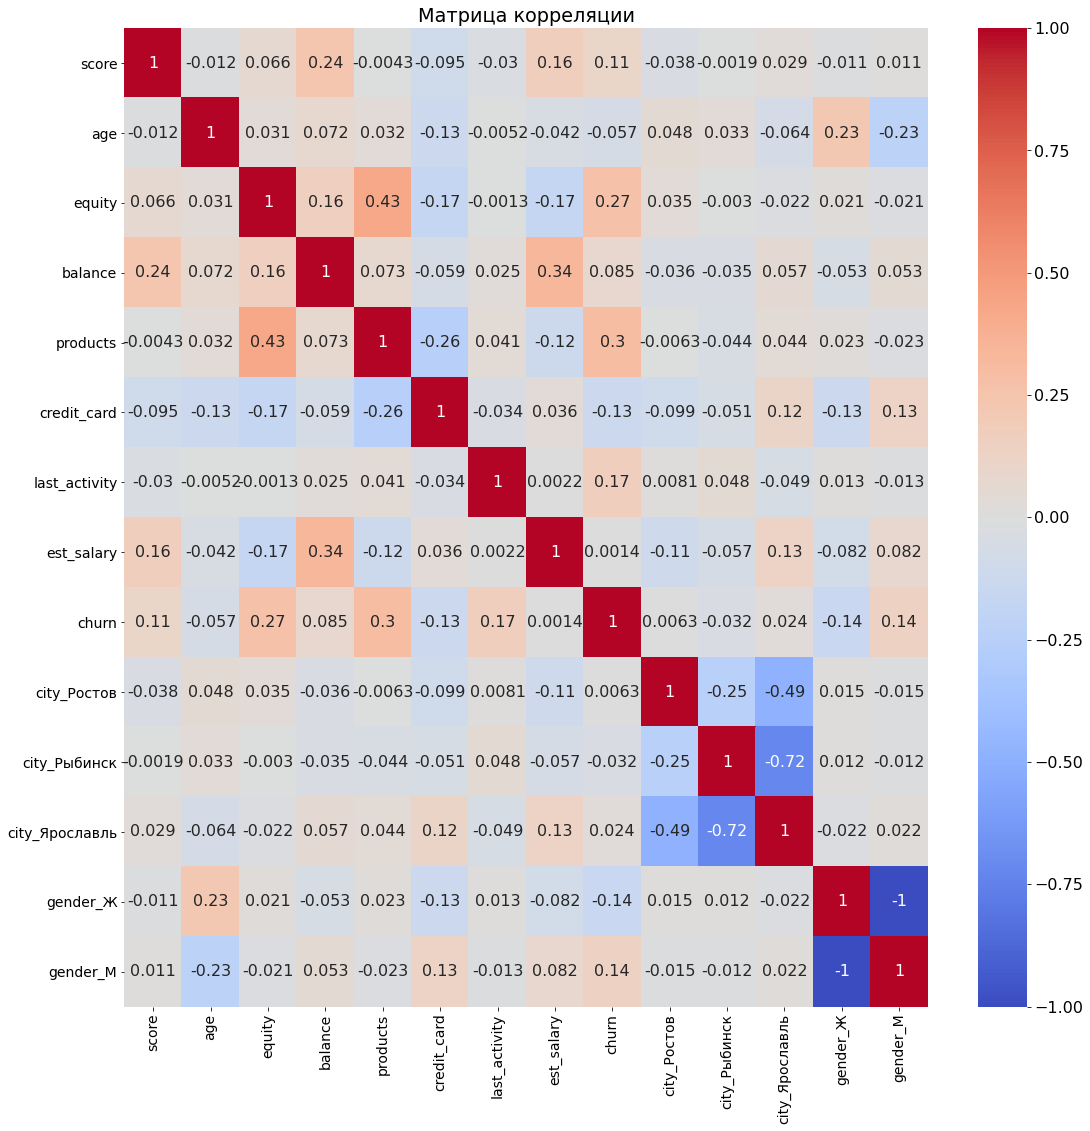

In [59]:
plt.figure(figsize = (18,18))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляции')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Построим отдельные тепловые карты корреляции признаков с оттоком и продуктами.

**Корреляция признаков с оттоком**

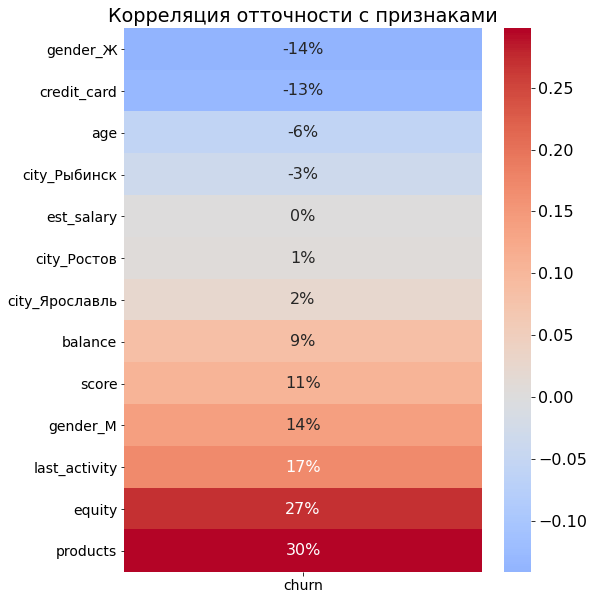

In [60]:
plt.figure(figsize = (8,10))
sns.heatmap(data_corr.loc[:,['churn']].drop('churn').sort_values('churn'), annot=True, fmt=".0%", cmap="coolwarm", center=0)
plt.title('Корреляция отточности с признаками')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Корреляция признаков с продуктами**

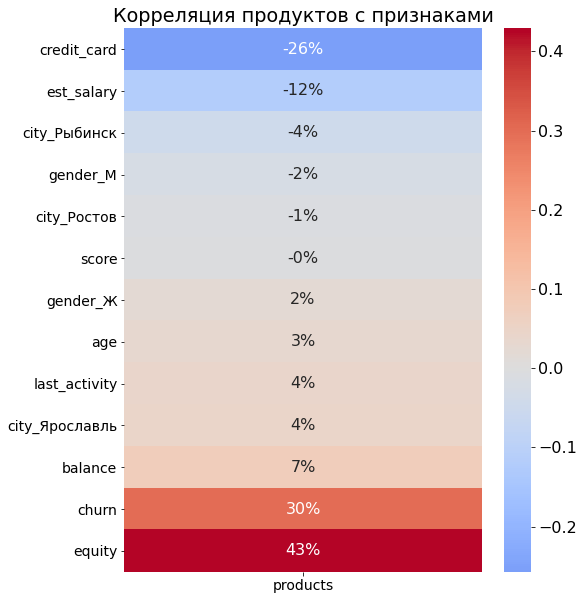

In [61]:
plt.figure(figsize = (8,10))
sns.heatmap(data_corr.loc[:,['products']].drop('products').sort_values('products'), annot=True, fmt=".0%", cmap="coolwarm", center=0)
plt.title('Корреляция продуктов с признаками')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Для оценки силы связи в теории корреляции применяется шкала Чеддока: 
 - слабая — от 0,1 до 0,3; 
 - умеренная — от 0,3 до 0,5; 
 - заметная — от 0,5 до 0,7; 
 - высокая — от 0,7 до 0,9; 
 - весьма высокая (сильная) — от 0,9 до 1,0.

Опишем силу связи между переменными, оттоком и продуктами согласно данной шкале.

**СИЛА СВЯЗИ ПЕРЕМЕННЫХ С ОТТОКОМ И ПРОДУКТАМИ ПО ШКАЛЕ ЧЕДДОКА**

| Переменная | Отток   | Продукты   |
| ------- | -------- | -------- |
| Скоринг   | Слабая    | Нет    |
| Возраст   | Нет    | Нет    |
| Собственность   | Слабая    | Умеренная    |
| Баланс   | Нет    | Нет    |
| Кредит.карта   | Нет    | Слабая (обратная)    |
| Активность   | Слабая    | Нет    |
| Зарплата   | Нет    | Слабая (обратная)    |
| г. Ростов   | Нет    | Нет    |
| г. Рыбинск   | Нет    | Нет    |
| г. Ярославль   | Нет    | Нет    |
| Жен.пол   | Слабая    | Нет    |
| Муж.пол   | Слабая    | Нет    |
| Продукты   | Умеренная    |     |
| Отток   |     | Умеренная   |

***Вывод:*** Из проведенного исследования видно, что большинство признаков между собой коррелируют слабо. 

Умеренная корреляция 43% - выявлена между количеством объектов недвижимости в собственности у клиента (equity) и количеством продуктов (products).

Также умеренная корреляция 30% наблюдается между продуктами и оттоком.

Стоит также отметить обратную корреляцию между продуктами и наличием кредитной карты, она составляет 26%. 

Наличие зависимостей, выявленных при проведении исследовательского анализа даных, подтвердилось корреляционным анализом.

## Проверка статистических гипотез

***Гипотеза 1:*** 

**Доходы клиентов, которые пользуются двумя продуктами банка, и клиентов, которые пользуются одним, различаются**

- H_0 (нулевая гипотеза): Доходы клиентов с одним и двумя продуктами не отличаются

- H_1 (альтернативная гипотеза): Доходы клиентов с одним и двумя продуктами отличаются

(alpha = 0.05)

In [62]:
data_1 = data['est_salary'].loc[data['products'] == 1]
data_2 = data['est_salary'].loc[data['products'] == 2]

In [63]:
data_1.describe()

count    3.306000e+03
mean     1.806162e+05
std      1.693484e+05
min      2.546300e+03
25%      9.047649e+04
50%      1.421831e+05
75%      2.048184e+05
max      1.333687e+06
Name: est_salary, dtype: float64

In [64]:
data_2.describe()

count    5.081000e+03
mean     1.307729e+05
std      1.174066e+05
min      5.341500e+03
25%      7.022840e+04
50%      1.098299e+05
75%      1.594957e+05
max      1.395064e+06
Name: est_salary, dtype: float64

Разница в средних и медианных значениях на первый взгляд существенна.

При проведении исследовательского анализа данных мы строили график распределения по зарплате. Распределение имело длинный хвост, совсем не похоже на нормальное. Выполним дополнительно проверку выборок на нормальность распределения, применив критерий Шапиро-Уилка 

In [65]:
warnings.filterwarnings('ignore')

for i, dt in enumerate([data_1, data_2]): 
    alpha = 0.05

    results = st.shapiro(dt)
    p_value = results[
        1
    ]

    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: распределение {i} не является нормальным')
    else:
        print(f'Не получилось отвергнуть нулевую гипотезу, {i} всё нормально')

Отвергаем нулевую гипотезу: распределение 0 не является нормальным
Отвергаем нулевую гипотезу: распределение 1 не является нормальным


In [66]:
data['est_salary'].skew()

4.096282415348834

**Выбор метода проверки гипотезы**

***1. T-критерий (критерий Стьюдента)***

Для примениния данного метода должны выполняться следующие условия:

- Генеральные совокупности не должны зависеть друг от друга. В нашем случае это условие выполняется.
- Выборочные средние должны быть нормально распределены. Это условие не выполняется, но согласно Центральной предельной теореме, если размер выборки составляет хотя бы несколько десятков значений, выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности. Наши выборки состоят из нескольких тысяч значений, т.е. они достаточно велики, а значит, мы можем применять для их сравнения t-критерий.


В настройках t-test укажем параметр equal_var = False, т.к. размеры выборок достаточно сильно отличаются (3,3 тыс. и 5 тыс. значений) и мы не знаем, равны ли дисперсии.

In [67]:
# выполним проверку t- критерием

# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    data_1, data_2, equal_var = False
)

alpha = 0.05  # критический уровень статистической значимости

print('p-value: ', results.pvalue)

if results.pvalue <= alpha:
    print('Отвергаем нулевую гипотезу ')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value:  2.0218467865427267e-48
Отвергаем нулевую гипотезу 


По результатам t-теста нулевая гипотеза не подтведилась.

***2. U-критерий (критерий Манна-Уитни)***

В качестве двухвыборочного критерия, как для зависимых, так и для независимых выборок можно применять u-критерий Манна-Уитни. Данный критерий подходит и для больших, и для маленьких выборок. Критерий Манна-Уитни выбирают при наличии в данных значительного числа выбросов (у нас в выборках они есть), т.к. алгебраические метрики в таких случаях работают плохо.

Посмотрим, будут ли отличаться результаты, если мы применим u-тест.

In [68]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(data_1, data_2, True) 

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  8.068363011059218e-76
Отвергаем нулевую гипотезу: разница статистически значима


***Вывод:*** По результатам теста нулевая гипотеза не подтведилась. Следовательно, мы можем сделать вывод, что доходы клиентов, использующих один и два продукта, отличаются.

Наиболее точным результатом в данном случае можно считать тот, который получили с применением U-критерия, т.к. в выборках есть большие выбросы, которые влияют на точность результата t-теста. 

***Гипотеза 2:*** 

**Среднее количество баллов кредитного скоринга уходящих и оставшихся клиентов отличается**

- H_0 (нулевая гипотеза): Баллы кредитного скоринга у уходящих и оставшихся клиентов равны

- H_1 (альтернативная гипотеза): Баллы кредитного скоринга у уходящих и оставшихся клиентов различаются

(alpha = 0.05)

In [69]:
# уходящие клиенты
data_scor_1 = data[data['churn'] == 1]['score']

# остающиеся клиенты
data_scor_0 = data[data['churn'] == 0]['score']

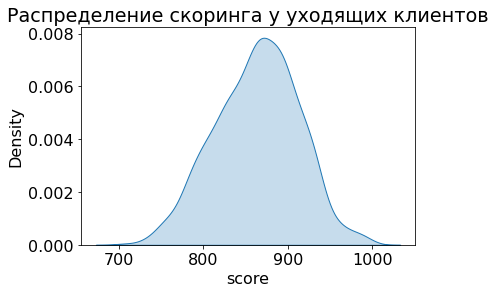

In [70]:
snsplot = sns.kdeplot(data_scor_1, shade=True)
fig = snsplot.get_figure()
plt.title('Распределение скоринга у уходящих клиентов')
plt.show()

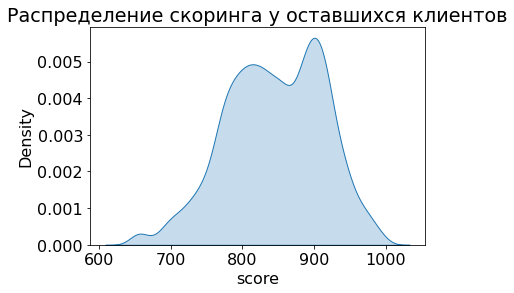

In [71]:
snsplot = sns.kdeplot(data_scor_0, shade=True)
fig = snsplot.get_figure()
plt.title('Распределение скоринга у оставшихся клиентов')
plt.show()

In [72]:
warnings.filterwarnings('ignore')

# применим критерий Шапиро-Уилка для проверки выборок на нормальность распрделения
for i, dt in enumerate([data_scor_0, data_scor_1]): 
    alpha = 0.05

    results = st.shapiro(dt)
    p_value = results[
        1
    ]

    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: распределение {i} не является нормальным')
    else:
        print(f'Не получилось отвергнуть нулевую гипотезу, {i} всё нормально')

Отвергаем нулевую гипотезу: распределение 0 не является нормальным
Отвергаем нулевую гипотезу: распределение 1 не является нормальным


В данном случае для сравнения подойдет критерий Стьюдента, т.к. мы сравниваем две выборки, которые имеют распределение отличное от нормального, но при этом, у них большой размер и в данных отсутствуют выбросы.

In [73]:
# проверка t-критерием Стьюдента
results = st.ttest_ind(
    data_scor_1, data_scor_0, equal_var = False
)

alpha = 0.05  # критический уровень статистической значимости

print('p-value: ', results.pvalue)

if results.pvalue <= alpha:
    print('Отвергаем нулевую гипотезу ')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value:  1.7319735940138187e-37
Отвергаем нулевую гипотезу 


В результате проведения тестов удалось выявить, что разница статистически значима, а значит, средний балл скоринга у ушедших и оставшихся клиентов различается.

Средняя величина скоринга ушедших клиентов - 863 балла

Средняя величина скоринга оставшихся клиентов - 845 баллов

**Вывод:** В банке остается больше клиентов с более низким рейтингом. 

## Сегментация на основе продуктов и стратегических показателей

In [74]:
data['products'].value_counts()

2    5081
1    3306
3    1035
4     474
5      30
Name: products, dtype: int64

При проведении анализа данных по клиентам "Метанпромбанка" были выявлены зависимости по некоторым признакам. 


Для сегментации клиентов воспользуемся результатами полученными в ходе исследования. Сегменты будем выделять с учетом количества используемых продуктов.

На графике зависимости оттока от количества продуктов мы видели, что между данными переменными прослеживается прямая зависимость. Коэффициент корреляции между ними умеренный, составляет 30%.

Рассчитаем, какое количество оттоков встречается в каждой из групп по продуктам и вычислим, сколько процентов эти оттоки составляют от общего числа оттоков в датасете.





Разделим сначала наши данные на три группы по количеству продуктов. В первые две группы будут, соотвественно, входить клиенты с одним и двумя продуктами. Т.к. они самые многочисленные, не будем их объединять. В третью группу объединим всех клиентов, которые используют 3 продукта и более.

In [75]:
# создадим новый датасет, в котором 1, 2 и 3+ продуктов
data_prod_3 = data_prod.copy()
data_prod_3['products'] = data_prod['products'].replace(4, 3)

In [76]:
in_churn = data_prod_3.query('churn==1')['userid'].count() # общее количество оттоков
in_churn_pr_1 = data_prod_3.query('churn == 1 and products == 1')['userid'].count() # количество оттоков с одним продуктом
in_churn_pr_2 = data_prod_3.query('churn == 1 and products == 2')['userid'].count() # количество оттоков с двумя продуктами
in_churn_pr_3 = data_prod_3.query('churn == 1 and products == 3')['userid'].count() # количество оттоков с тремя продуктами

in_pr1 = data_prod.query('products == 1')['userid'].count()
in_pr2 = data_prod.query('products == 2')['userid'].count()
in_pr3 = data_prod.query('products == 3')['userid'].count()

print(f'\nКоличество оттоков в группе с 1 продуктом: {in_churn_pr_1}, \
      \n{in_churn_pr_1/in_churn:.1%} от общего числа оттоков \
      \n{in_churn_pr_1/in_pr1:.1%} от клиентов в группе' )
print(f'Количество оттоков в группе с 2 продуктами: {in_churn_pr_2}, \
      \n{in_churn_pr_2/in_churn:.1%} от общего числа оттоков \
      \n{in_churn_pr_2/in_pr2:.1%} от клиентов в группе' )
print(f'Количество оттоков в группе с 3+ продуктами: {in_churn_pr_3},\
      \n{in_churn_pr_3/in_churn:.1%} от общего числа оттоков \
      \n{in_churn_pr_3/in_pr3:.1%} от клиентов в группе' )



Количество оттоков в группе с 1 продуктом: 235,       
12.9% от общего числа оттоков       
7.1% от клиентов в группе
Количество оттоков в группе с 2 продуктами: 978,       
53.7% от общего числа оттоков       
19.2% от клиентов в группе
Количество оттоков в группе с 3+ продуктами: 607,      
33.4% от общего числа оттоков       
58.6% от клиентов в группе


Процент отточных клиентов в группе с одним продуктом очень мал. 93% пользователей одного продукта остаются в банке. Какой-то значимый сегмент по признакам, влияющим на отток, врядли удастся выделить, т.к. оттока, как такового в данной категории практически нет.

Из клиентов в категории с двумя продуктами уходит почти каждый пятый. С учетом того, что данная категория самая многочисленная - отток такого количества клиентов слишком велик, необходимо выделить сегменты с учетом показателей влияющих на отток.

Из клиентов с тремя и более продуктами уходит более половины. Эта категория не такая многочисленная, но в ней преобладают клиенты с высокой оценкой собственности, с хорошими показателями по скорингу и с более высоким балансом на счете. А самое главное, такие клиенты использовали большое число банковских продуктов, а, значит, приносили много прибыли банку. Определение отточных сегментов из этих категорий также является важной задачей.

- Первыми выделим клиентов с одним продуктом, попадающих в интервал с высоким рейтингом по скорингу
- Затем выделим клиентов, у которых высокий скоринг, возраст с 48 до 60 лет, использующих два продукта банка, не использующих кредитную карту 
- В третий сегмент выделим клиентов, у которых высокий скоринг, возраст с 48 до 60 лет, использующих три и более продукта банка, не использующих кредитную карту 
- Четвертым сегментом будут пользователи, с высоким скорингом, возраст от 25 до 36 лет, используют два продукта банка, не используют кредитную карту
- Пятый сегмент - клиенты с высоким скорингом, возраст от 25 до 36 лет, используют три и более продукта банка, не используют кредитную карту
- В шестой сегмент выделим людей, которые используют один продукт, имеют оценку собственности более 3 и возраст от 25 до 36 лет
- Седьмой сегмент - клиенты, использующие один продукт, не являющийся кредитной картой.

In [77]:
in_churn = data.query('churn==1').index

print('Всего отточных в датасете: ', len(in_churn), '\n')

# задаем условия для сегментов

segment1 = [data.query('(820 <= score <= 940) and products == 1')]

segment2 = [data.query('(820 <= score <= 940)  and products == 2'), 
            data.query('(48 < age < 60) and (credit_card == 0)  and products == 2')]

segment3 = [data.query('(820 <= score <= 940)  and products >= 3'),
           data.query('(48 < age < 60)  and (credit_card == 0) and products >= 3')]

segment4 = [data.query('(820 <= score <= 940)  and products == 2'),
           data.query('(25 <= age <= 36) and (credit_card == 0) and products == 2')]

segment5 = [data.query('(820 <= score <= 940)  and products >= 3'),
           data.query('(25 < age < 36) and (credit_card == 0) and products >= 3')]

segment6 = [data.query('(25 <= age < 36) and (equity > 3) and products == 1')]

segment7 = [data.query('(credit_card == 0) and products == 1')]


# цикл проверки отточности по каждому выделенному сегменту
for i, segment in enumerate ([segment1, segment2, segment3, segment4, segment5, segment6, segment7]):
    seg_idx = [seg.index for seg in segment]
    churn_idx = [seg.query('churn==1').index for seg in segment]
    in_selection = reduce(set().union,seg_idx)
    in_selection_churn = reduce(set().union,churn_idx)
    not_in_selection = in_churn.difference(in_selection)

    print(
          f'СЕГМЕНТ {i+1}',
          '\nПопало в сегментацию клиентов всего:',len(in_selection),
          '\nПопало в сегментацию отточных:',len(in_selection_churn),
          '\nНе попало в сегментацию отточных:',len(not_in_selection),
          f'\nПроцент успеха (относительно всех отточных клиентов): {len(in_selection_churn)/len(in_churn):.1%}',
          f'\nПроцент успеха (относительно всех клиентов внутри сегмента): {len(in_selection_churn)/len(in_selection):.1%}',
          '\n'
          )

Всего отточных в датасете:  1820 

СЕГМЕНТ 1 
Попало в сегментацию клиентов всего: 2003 
Попало в сегментацию отточных: 158 
Не попало в сегментацию отточных: 1662 
Процент успеха (относительно всех отточных клиентов): 8.7% 
Процент успеха (относительно всех клиентов внутри сегмента): 7.9% 

СЕГМЕНТ 2 
Попало в сегментацию клиентов всего: 3165 
Попало в сегментацию отточных: 811 
Не попало в сегментацию отточных: 1009 
Процент успеха (относительно всех отточных клиентов): 44.6% 
Процент успеха (относительно всех клиентов внутри сегмента): 25.6% 

СЕГМЕНТ 3 
Попало в сегментацию клиентов всего: 1007 
Попало в сегментацию отточных: 452 
Не попало в сегментацию отточных: 1368 
Процент успеха (относительно всех отточных клиентов): 24.8% 
Процент успеха (относительно всех клиентов внутри сегмента): 44.9% 

СЕГМЕНТ 4 
Попало в сегментацию клиентов всего: 3206 
Попало в сегментацию отточных: 801 
Не попало в сегментацию отточных: 1019 
Процент успеха (относительно всех отточных клиентов): 44.

- Сегмент 1. Не является отточным. Рекомендации в данном случае не нужны.

- Сегмент 2. В отток попадает 811 чел., что составляет 25.6% - это высокие показатели. По сегменту будут даны рекомендации.

- Сегмент 3. В отток попадает 452 чел., что составляет 44.9% - это высокие показатели. По сегменту будут даны рекомендации. 

- Сегмент 4. В отток попадает 801 чел., что составляет 25% - также высокие показатели. По сегменту будут даны рекомендации. 

- Сегмент 5. В отток попадает 444 чел., что составляет 43.8% - также высокие показатели. По сегменту будут даны рекомендации.

- Сегмент 6. В отток попадает 57 чел., что составляет 27.4% - показатель по количеству отточных клиентов невысокий, но с учетом того, что среди категории пользователей с одним продуктом отток очень маленький, по сегменту будут даны рекомендации.

- Сегмент 7. Не является отточным. Рекомендации в данном случае не нужны.

## Выводы и рекомендации для заказчика

В проекте были выполнены следующие задачи:
- Проведен исследовательский анализ, включающий исследование корреляций и портретов клиентов
- Выполнена проверка двух гипотез
- Выявлено, какие признаки влияют на количество используемых продуктов
- Выделены, с применением количества продуктов, высокоотточные сегменты и выполнена их приоритизация

Перед началом проведения анализа данных была выполнена предобработка денных, в результате которой было выявлено достаточно большое количество пропусков в столбце balance. Было установлено, что пропуски не совсем случайны. Из-за высокого процента наличия пропусков записи с их наличием решено оставить без изменения, с условием, что они будут учтены в работе.

Анализ данных показал следующие особенности:

•	Наибольшее число клиентов с низким рейтингом (примерно от 600 до 740) - используют один продукт. От 740 до примерно 820 - преобладают пользователи с тремя продуктами, от 820 до 910 баллов больше всего имеют пользователи с большим количеством продуктов (4+). Большинство пользователей с двумя продуктами имеют кредитный рейтинг примерно от 750 до 920 баллов. •	Достаточно многочисленный сегмент, имеющий высокий кредитный рейтинг (820-940 баллов) является отточным.

•	Наибольшее число клиентов имеет зарплату не превышающую 200 000 руб. Среди клиентов, имеющих зарплату от 100 000 руб. до 220 000 руб. больше тех, кто уходит из банка.  С меньшей зарплатой отточности нет.

•	По возрасту клиенты рапсределились следующим образом: от 18 до 22 лет - небольшая категория клиентов, продуктов они используют примерно одинаково. В интервале с 25 и до 40 лет видны явные различия по распределению продуктов - наибольший процент клиентов использует 4-5 продуктов, затем идут с одним и двумя продуктами примерно в равном соотношении, и наименьший процент из категории использует три продукта. С 40 до 55 лет - соотношение по количеству продуктов примерно одинаковое или имеет небольшое отличие. У пользователей старше 55 лет, как правило, три продукта, меньше всего из этой возрастной категории клиенты имеют по 4-5 продуктов. По возрасту в интервалах с 25 до 36 лет и с 50 до 61 года - преобладает отток.

•	По балансу на счете. До 600 тыс. руб. преобладают пользователи с 1-2 продуктами. Клиенты, у которых баланс свыше 1 млн. руб., как правило исользуют 3 и более продукта. Клиенты, у которых баланс превышает 750 000 руб. в основном уходят из банка.

•	Прослеживается явная прямая связь между признаками количества продуктов и оценкой собственности: чем выше показатель собственности, тем больше продуктов. Среди тех, кто имеет оценку собственности 3+ преобладают уходящие в отток клиенты.

•	Среди обладателей кредитных карт явный перевес в пользу клиентов с одним продуктом. Процент оттока у обладателей кредитных карт невысокий, а вот те, кто данный продукт не использует, в основном уходят. Условия кредитных карт явно нравятся нашим клиентам, стоит задуматься о мерах продвижения данного продукта.

•	По активности пользователи с одним и двумя продуктами примерно одинаковы. С тремя проявляют чуть меньшую активность. Самая активная категория - клиенты с 4 и 5 продуктами. Большая часть активных пользователей уходит из банка, а неактивных остается. Но мы точно не знаем, какая именно активность подразумевается в наших данных. Возможно активность связана как раз с закрытием продуктов.

•	В городах Ярославской области процент клиентов, использующих 1-2 продукта немного выше. В Ярославле наоборот, пользователи чаще используют 3 и более продуктов. Во всех городах соотношение отточных и неотточных клиаентов примерно одинаковое, город явно не влияет на такой признак, как отточность.

•	По половому признаку каких-то существенных различий по количеству потребляемых продуктов не выявлено. По 2 и 3 продукта используют немного чаще женщины, по 1 и 4+ - мужчины. Процент оттока среди мужчин выше.

***В целом, по всем наблюдениям можно заключить, что из нашего банка уходит много клиентов имеющих высокую зарплату, хороший показатель кредитного скоринга, высокую оценку собственности, большую сумму на балансе счета. Т.е. это обеспеченные, платежеспособные клиенты. Видимо, в банке нет выгодных условий по программам кредитования. Также, возможно, плохо развита работа с VIP-клиентами. Стоит почаще проводить опросы по удовлетворенности обслуживания пользователей банком.***

***Также плохо задерживается в банке молодежь, возможно, для них не предусмотрены никакие молодежные программы. Стоит предложить, например, бесплатное обслуживание дебетовых карт для студентов.***

***Есть явно хороший продукт, который точно стоит рекомендовать пользователям - это кредитная карта. Большинство остальных продуктов явно требует улучшения.***



**Сегменты с высокой отточностью и рекомендации для отдела маркетинга:**

- **Сегмент 2 (811 чел., 25,6% отток в сегменте) и Сегмент 3 (452 чел., 44,9% отток в сегменте)** - клиенты в возрасте от 48 до 60 лет, с хорошей кредитной историей (скоринг: 820-940), потребители от 2 до 5 продуктов банка. 

Рекомендации: 

1. Сделать интересное предложение с учетом возраста клиента. Тех, кому ближе к 60 годам, возможно, заинтересовали бы выгодные условия по пенсионным вкладам и картам.
2. Стоит провести анкетирование, чтобы узнать причины по которым клиент уходит из банка. По результатам подготовить выгодные предложения с учетом ответов клиента. 
3. Предложить более выгодные условия кредитования, с учетом потребностей клиента. Клиенты с высоким рейтингом скоринга привлекательны для других банков, как надежные плательщики. Возможно, сейчас уход из банка связан именно с этой причиной и выгодное предложение поможет удержать.
3. Если клиент не использует кредитную карту, то ее можно предложить, т.к. данный продукт явно нравится клиентам нашего банка.
4. Проверить не является ли клиент - зарплатным клиентом, т.к. часто зарплатные клиенты пользуются целым пакетом выгодных услуг, а при увольнении с работы теряет все преимущества. Если причина связана с этим, то, возможно, в качестве первой меры по удержанию стоит предложить бесплатное обслуживание дебетовой карты, на которую переводилась зарплата, а далее провести анализ, что именно клиент теряет и, на основании этого, сделать предложение.


- **Сегмент 4 (801 чел., 25% отток в сегменте) и Сегмент 5 (444 чел., 43.8% отток в сегменте)** - клиенты в возрасте от 25 до 36 лет, с хорошей кредитной историей (скоринг: 820-940), потребители от 2 до 5 продуктов банка. 

Рекомендации: 
1. Подходят рекомендации 1 - 5, описанные для сегментов 2 и 3. 
2. Учесть возрастные особенности. Люди в возрасте 25 - 36 лет очень активны. Возможно, стоит предложить повышенные кешбеки при оплате картой банка. Можно разработать для таких клиентов партнерские программы совместно, например, с туристическими компаниями или фитнес-центрами. 

- **Сегмент 7 (57 чел., 27.4% отток в сегменте)** - клиенты имеют оценку собственности более 3 и возраст от 25 до 36 лет, используют 1 продукт. Данный сегмент малочисленный относительно всей выборки, но из сегмента уходит почти треть клиентов, еще достаточно молодые, но уже обеспеченные люди, судя по оценке собственности, они попробовали в нашем банке один продукт, и им он не понравился. По остальным продуктам, условия, их видимо, не заинтересовали. 

Таким клиентам можно предложить:
1. Различные инвестиционные программы.
2. Повышенные кешбеки и бонусные программы.


**Результаты проверки гипотез**

***Гипотеза 1.*** Доходы клиентов, которые пользуются двумя продуктами банка, и клиентов, которые пользуются одним, различаются.

Гипотеза подтвердилась. Доходы различаются.

***Гипотеза 2.*** Среднее количество баллов кредитного скоринга уходящих и оставшихся клиентов отличается

Вторая гипотеза о различии среднего количества баллов кредитного скорринга также подтвердилась.

**Презентация**

<https://disk.yandex.ru/i/BhehjPCD_Di_8Q>

**Дашборд**

<https://public.tableau.com/app/profile/helga4730/viz/bank_metanprom_16774376600990/Dashboard1#1>